In [1]:
#from libs.prefect_helpers import *
from libs.data_manipulation import *
from libs.feature_generation import *
from libs.dim_reduction import *
from libs.football_plots import *
from libs.clustering import *
from libs.convex_hull import *

import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

from mplsoccer import *
import pandas as pd
import numpy as np
import os
# Click player into the pitch and take those player and apply Ripleys K to them. And then maybe PCA


In [2]:
# Step 6: Extract match data from tracking data
data = compile_team_tracking_data("data", "DEN")
print(data.head())
one_match = extract_one_match(data, 1)
ripley_k_whole_match = ripley_k_by_indices(one_match, one_match.iloc[::48].index)


   frame_team  Time [s]_team half_team  home_1_x  home_1_y  home_3_x  \
0           0           0.00        1H     52.49     -0.08     19.96   
1           1           0.04        1H     52.51     -0.06     19.95   
2           2           0.08        1H     52.53     -0.05     19.95   
3           3           0.12        1H     52.51     -0.06     19.94   
4           4           0.16        1H     52.51     -0.05     19.94   

   home_3_y  home_4_x  home_4_y  home_5_x  ...  away_19_y  away_22_x  \
0      0.13     21.84     10.54     18.66  ...        NaN      -0.41   
1      0.14     21.87     10.56     18.68  ...        NaN      -0.40   
2      0.15     21.89     10.57     18.70  ...        NaN      -0.34   
3      0.16     21.90     10.58     18.73  ...        NaN      -0.29   
4      0.17     21.92     10.59     18.76  ...        NaN      -0.23   

   away_22_y  away_23_x  away_23_y  away_26_x  away_26_y  ball_x  ball_y  \
0      28.75      -0.43      33.28        NaN        NaN  

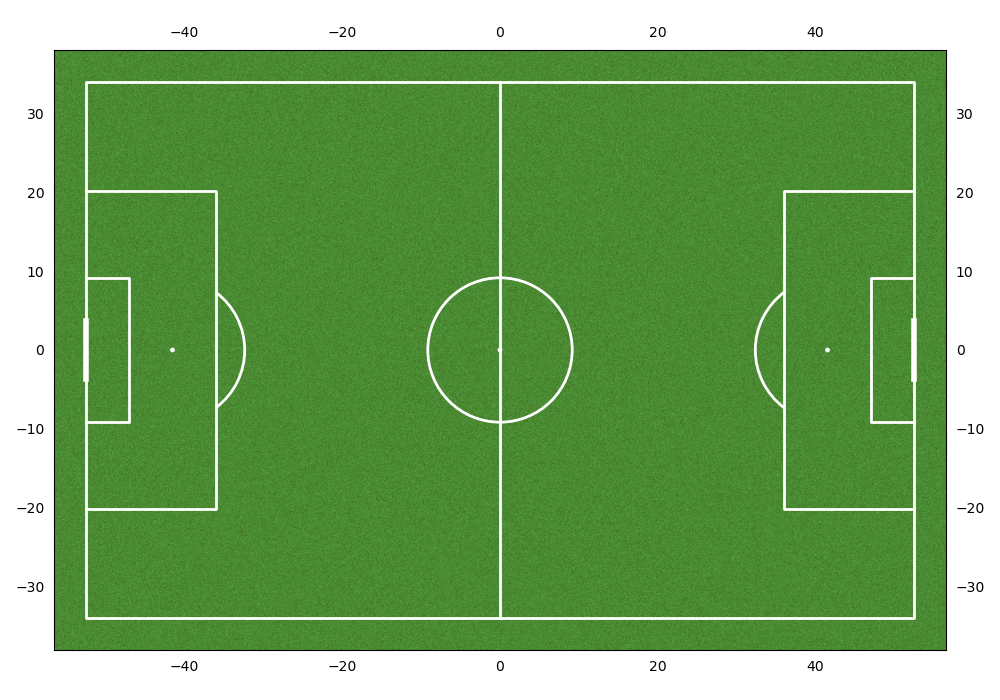

Cleared the current situation. You can now draw a new one.
Situation saved! Total saved situations: 1


In [3]:
%matplotlib widget

import matplotlib.pyplot as plt
from mplsoccer import Pitch
import ipywidgets as widgets
from IPython.display import display

# Initialize plot
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
fig, ax = football_pitch.draw(figsize=(10, 7))

# List to store points for the current situation and vectors
players =[]
points = []
vectors = []
situations = []

# Boolean to check if we're in vector drawing mode
draw_vector_mode = False
vector_start = None  # To store the start point of the vector

# Function to handle mouse clicks for points and vectors
def on_click(event):
    global vector_start, draw_vector_mode
    
    if event.inaxes:  # Check if click is inside plot
        x, y = event.xdata, event.ydata  # Get coordinates
        
        if draw_vector_mode:
            if vector_start is None:  # If no start point, set this as start point
                vector_start = (x, y)
                ax.plot(x, y, 'bo')  # Mark the start point with a blue dot
            else:
                # If there's already a start point, draw the vector from start to this point
                vector_end = (x, y)
                ax.annotate('', xy=vector_end, xytext=vector_start,
                            arrowprops=dict(facecolor='red', shrink=0.05))  # Draw vector
                vectors.append((vector_start, vector_end))  # Save the vector
                vector_start = None  # Reset the start point
        else:
            points.append((x, y))  # Add to list of points
            ax.plot(x, y, 'ro')  # Plot the point
        
        plt.draw()  # Redraw the figure

# Function to save the current situation
def save_situation(_):
    if points or vectors:
        situations.append({'points': list(points), 'vectors': list(vectors)})  # Save the current points and vectors
        print(f"Situation saved! Total saved situations: {len(situations)}")
    else:
        print("No players or vectors to save!")

# Function to clear the current situation
def clear_situation(_):
    global points, vectors, vector_start
    points = []  # Clear the current points
    vectors = []  # Clear the current vectors
    vector_start = None  # Reset vector start point
    ax.cla()  # Clear the plot
    football_pitch.draw(ax=ax)  # Redraw the empty pitch
    plt.draw()
    print("Cleared the current situation. You can now draw a new one.")

# Function to toggle vector drawing mode
def toggle_draw_vector(_):
    global draw_vector_mode
    draw_vector_mode = not draw_vector_mode  # Toggle the mode
    if draw_vector_mode:
        print("Vector drawing mode enabled. Select start and end points for the vector.")
    else:
        print("Switched to player drawing mode.")

def select_player(player_num):
    players.append(player_num)
    print(players)

def remove_player(player_num):
    try:
        players.remove(player_num)
        print(players)
    except:
        print("Player not in list")

# Create save, clear, and toggle vector buttons
save_button = widgets.Button(description="Save Situation", button_style='success')
clear_button = widgets.Button(description="Clear", button_style='warning')
toggle_vector_button = widgets.Button(description="Toggle Draw Vector", button_style='info')

#Create buttons for player filter
buttons = []
#Get unique players
players_xy = one_match.filter(regex="^home").columns.to_numpy()
player_numbers = np.array([player[:-1] for player in players_xy])
player_numbers = np.unique(player_numbers)


for number in player_numbers:
    save_button_player = widgets.Button(description=str(number))
    undo_button = widgets.Button(description="remove player "+str(number))
    save_button_player.on_click(lambda _, n=number: select_player(n))
    undo_button.on_click(lambda _, n=number: remove_player(n))
    buttons.append(save_button_player)
    buttons.append(undo_button)
    




# Connect button click events to their functions
save_button.on_click(save_situation)
clear_button.on_click(clear_situation)
toggle_vector_button.on_click(toggle_draw_vector)
buttons.append(save_button)
buttons.append(clear_button)
buttons.append(toggle_vector_button)
# Connect the click event to the handler
fig.canvas.mpl_connect('button_press_event', on_click)



# Display the buttons below the plot
display(widgets.HBox(buttons))

plt.show()



In [4]:
regex = ""
for player in players:
    regex += "^"+player + "|" 
regex = regex[:-1]


#one_match = one_match.filter(regex = regex)
print(one_match.columns)

Index(['Time [s]', 'frame_team', 'Time [s]_team', 'half_team', 'home_1_x',
       'home_1_y', 'home_3_x', 'home_3_y', 'home_4_x', 'home_4_y', 'home_5_x',
       'home_5_y', 'home_6_x', 'home_6_y', 'home_8_x', 'home_8_y', 'home_9_x',
       'home_9_y', 'home_14_x', 'home_14_y', 'home_18_x', 'home_18_y',
       'home_20_x', 'home_20_y', 'home_23_x', 'home_23_y', 'ball_x_team',
       'ball_y_team', 'Period_team', 'frame', 'half', 'away_2_x', 'away_2_y',
       'away_3_x', 'away_3_y', 'away_7_x', 'away_7_y', 'away_11_x',
       'away_11_y', 'away_13_x', 'away_13_y', 'away_14_x', 'away_14_y',
       'away_15_x', 'away_15_y', 'away_16_x', 'away_16_y', 'away_17_x',
       'away_17_y', 'away_22_x', 'away_22_y', 'away_23_x', 'away_23_y',
       'ball_x', 'ball_y', 'Period'],
      dtype='object')


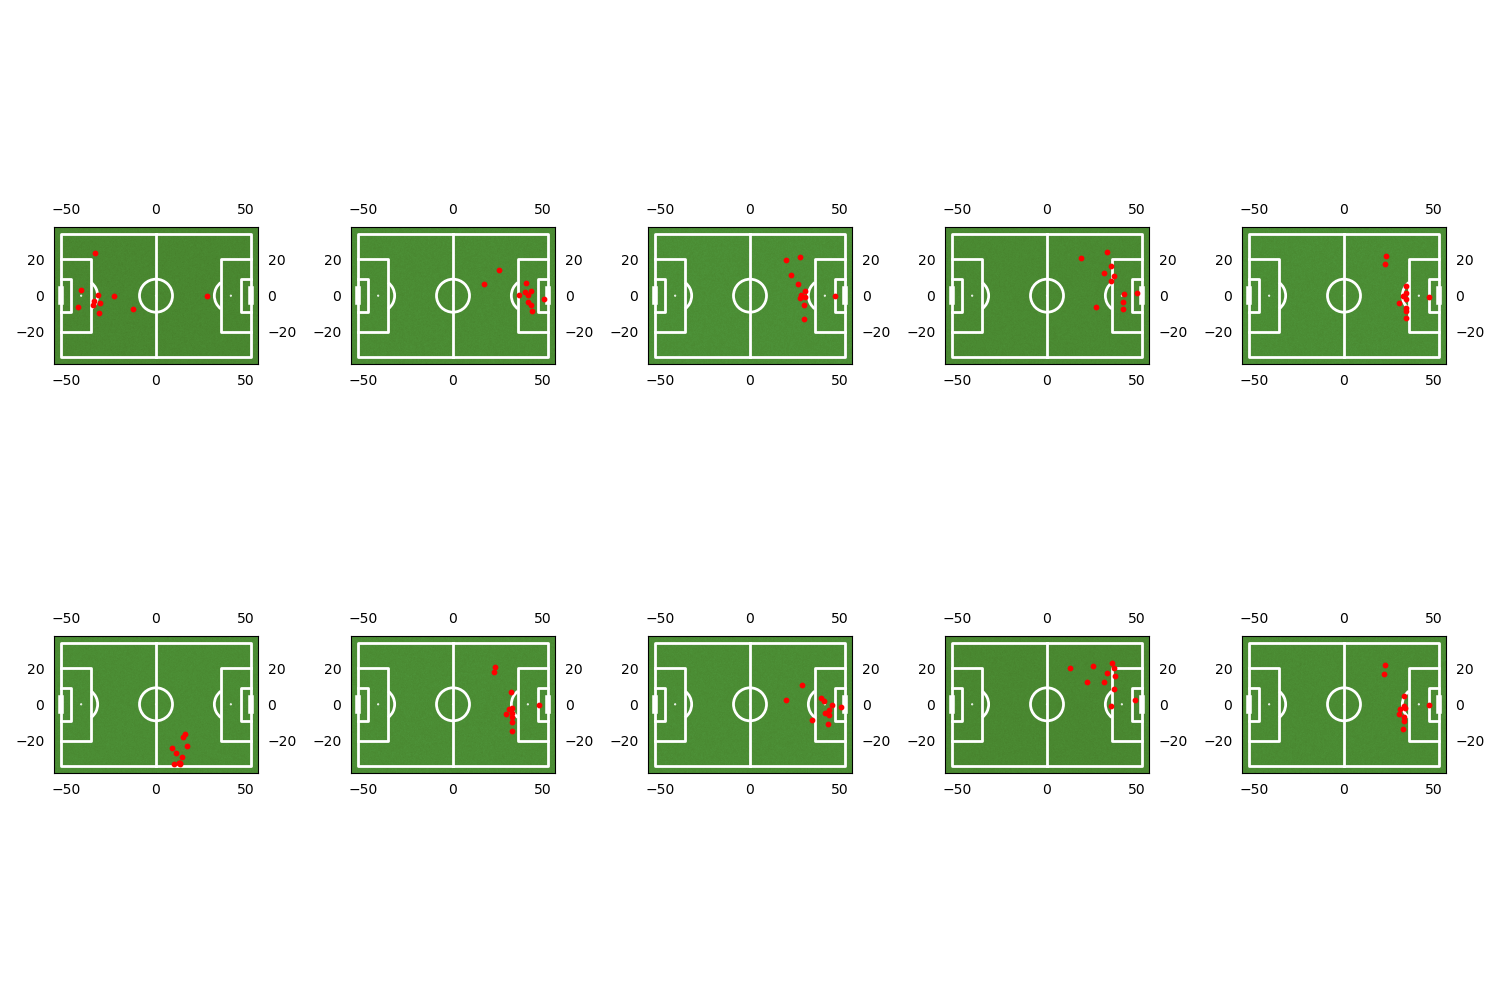

In [7]:

from libs.alpha_shape import *

alpha = 0.3

alpha_shapes, indices = alpha_shape(one_match.iloc[::48],alpha=alpha)

chosen_alpha_shape = alphashape.alphashape(points, alpha=alpha)
chosen_alpha_shape = normalize_geometry(chosen_alpha_shape)

top_100_alpha_shapes = top_n_similar_geometries(chosen_alpha_shape, alpha_shapes, indices, 100)


relevant_situations = np.array(top_100_alpha_shapes)[:,1]

fig, ax = plt.subplots(2, 5, figsize=(15, 10))

data = one_match.filter(regex = "^home")

# Create the pitch with the desired settings
for hull, i in zip(top_100_alpha_shapes[:10], range(len(top_100_alpha_shapes[:10]))):
    row = i // 5  # Determine the row index
    col = i % 5   # Determine the column index
    
    # Create a new pitch on each subplot
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, 
                           label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax[row, col])  # Draw the pitch on the current axis
    
    point_pairs = data.loc[hull[1]].to_numpy()

    points_current = np.array([np.array(list(pair)) for pair in zip(point_pairs[:-1:2], point_pairs[1::2])])


    # Scatter plot for convex hull points
    ax[row, col].scatter(points_current[:, 0], points_current[:, 1], color='red', s=10)

plt.tight_layout()
plt.show()

[(-35.732004360691484, -0.1267092353215986), (-22.427534651923374, 12.164086590873701), (-23.187790063852987, 1.6472200591808175), (-23.948045475782592, -6.208752530758446), (-15.078399003270519, 27.24248559414422), (-15.711945179878526, 12.544214296838504), (-15.58523594455692, 5.448497118828847), (-16.59890982712973, -5.955334060115241), (-16.218782121164928, -17.105746768416132), (-10.13673882572808, 10.13673882572808), (-6.588880236723256, 1.6472200591808175)]
10560
56592
112704
10512
119136
10800
90720
56544
33936
132144


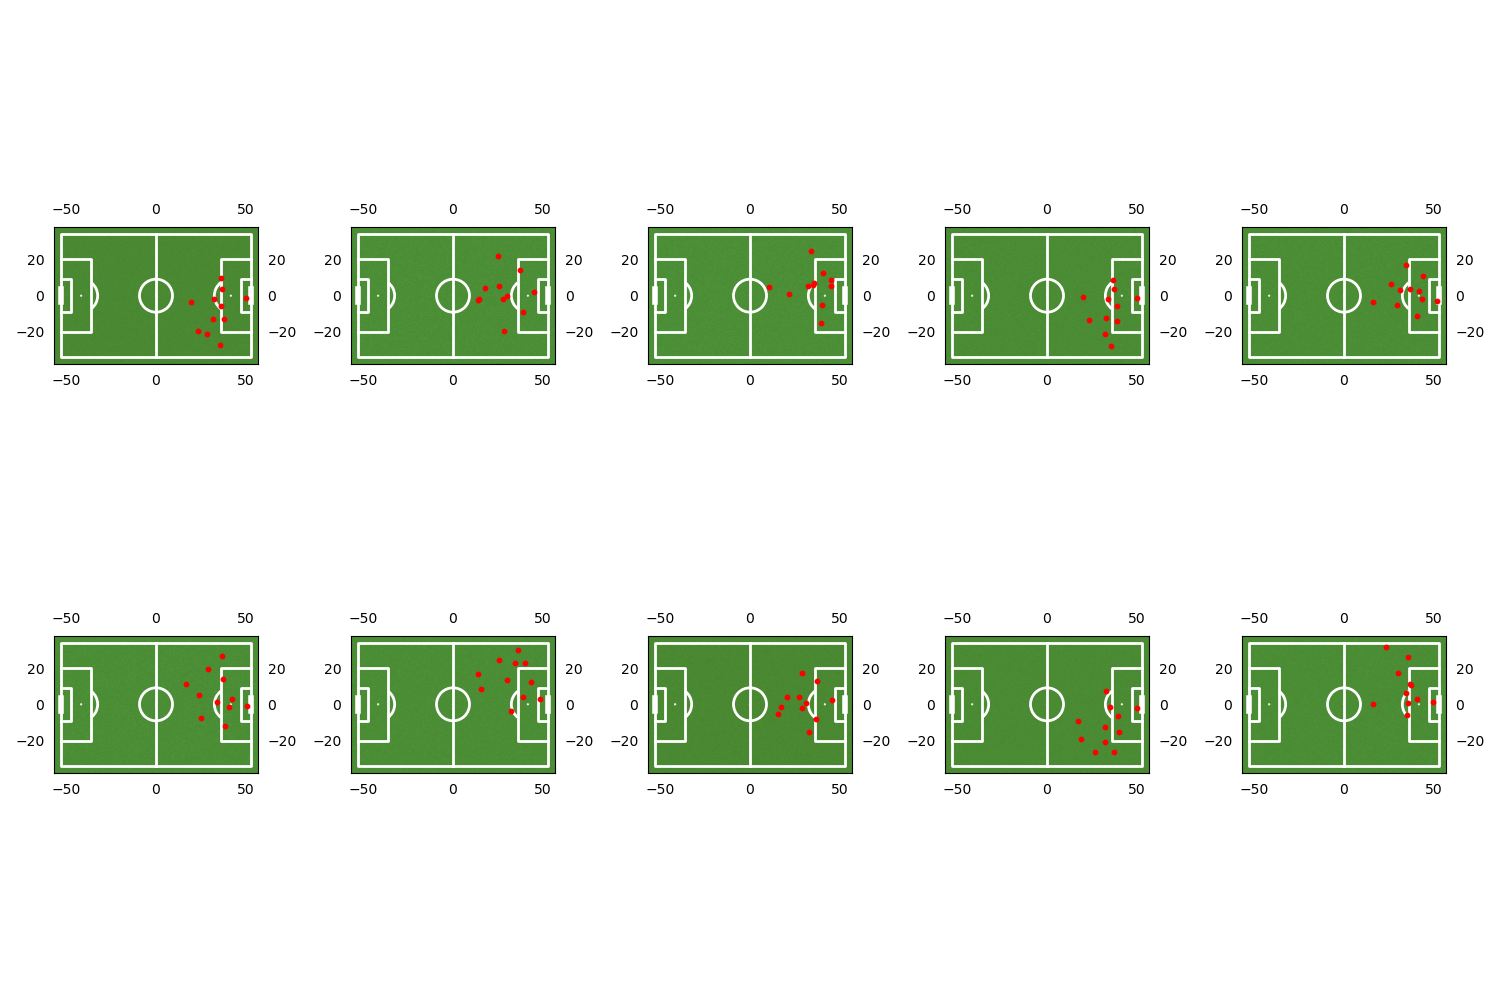

[0.0, 0.0, 0.0, 236.03305785123968, 590.0826446280992, 826.1157024793389, 1298.1818181818182, 1652.2314049586778, 2006.2809917355373, 2360.3305785123966, 2478.347107438017, 3068.4297520661157, 3422.4793388429753, 3658.512396694215, 3894.545454545455, 4012.5619834710747, 4130.578512396694, 4248.5950413223145, 4248.5950413223145, 4248.5950413223145, 4248.5950413223145, 4248.5950413223145, 4248.5950413223145, 4248.5950413223145, 4248.5950413223145, 4248.5950413223145, 4248.5950413223145, 4366.611570247935, 4484.628099173554, 4484.628099173554, 4484.628099173554, 4484.628099173554, 4484.628099173554, 4956.694214876034]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 236.03305785123968, 708.0991735537191, 826.1157024793389, 1180.1652892561983, 1416.1983471074382, 1652.2314049586778, 2006.2809917355373, 2360.3305785123966, 2714.380165289256, 2832.3966942148763, 3068.4297520661157, 3304.4628099173556, 3658.512396694215, 4012.5619834710747, 4484.628099173554, 4838.677685950413, 4956.694214876034, 5074.710

In [4]:
from libs.convex_hull import *

hulls, indices = convex_hull(one_match.iloc[::48])

chosen_hull = ConvexHull(points)
chosen_hull = normalize_hull(chosen_hull)

top_100_hulls = top_n_similar_hulls(chosen_hull, hulls,indices,100)

relevant_situations = np.array(top_100_hulls)[:,1]

fig, ax = plt.subplots(2, 5, figsize=(15, 10))

# Create the pitch with the desired settings
for hull, i in zip(top_100_hulls[:10], range(len(top_100_hulls[:10]))):
    row = i // 5  # Determine the row index
    col = i % 5   # Determine the column index
    print(hull[1])
    # Create a new pitch on each subplot
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, 
                           label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax[row, col])  # Draw the pitch on the current axis
    
    # Scatter plot for convex hull points
    ax[row, col].scatter(hull[0].points[:, 0], hull[0].points[:, 1], color='red', s=10)

plt.tight_layout()
plt.show()
radii = np.arange(0, 34)

print(ripley_k(one_match.loc[85920].filter(regex ="^home"), radii, width=105.0, height=68.0))
points_array = np.array(points)
points_series = pd.Series(points_array.flatten())
print(ripley_k(points_series, radii, width=105.0, height=68.0))


Collected 11 points.
0    -52.711042
1     33.831366
2    -36.365551
3     14.571562
4    -37.886061
5     11.910668
6    -38.139480
7      7.729263
8    -39.153154
9      1.900639
10   -34.464912
11     1.773929
12   -35.351877
13     6.082043
14   -35.098458
15    10.390157
16   -27.115776
17     2.534185
18   -18.372839
19     6.842299
20    34.718330
21     2.154057
dtype: float64


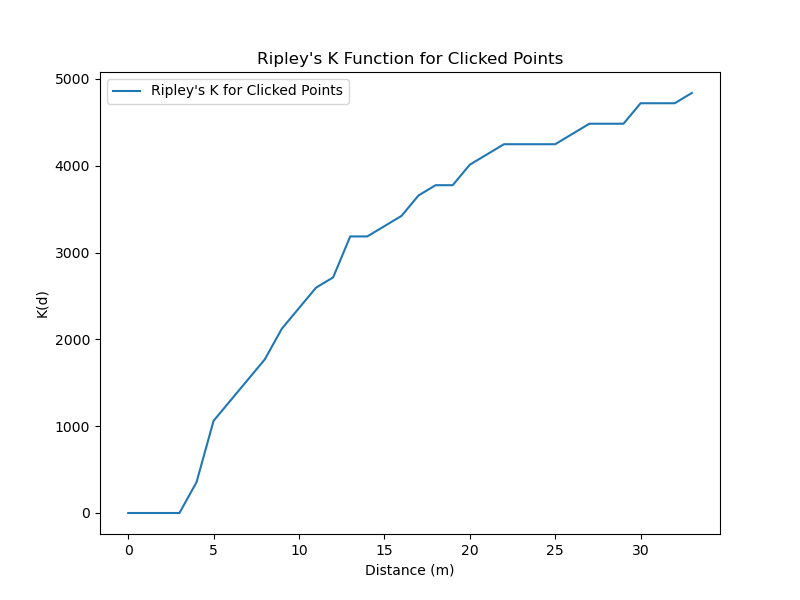

In [8]:
# Ensure the interactive pitch has captured points
if not points:
    print("Please click on the pitch to add points.")
else:
    print(f"Collected {len(points)} points.")

# Step 2: Convert the points from the interactive pitch into a usable format
points_array = np.array(points)  # Convert the collected points into a NumPy array

if points_array.shape[0] > 1:
    # Flatten the points for Ripley's K
    points_series = pd.Series(points_array.flatten())
    print(points_series)

    # Step 3: Define the radii for Ripley's K
    radii = np.arange(0, 34)  # Adjust the range based on your use case

    # Step 4: Calculate Ripley's K for the clicked points
    k_values_clicked = ripley_k(points_series, radii, width=105.0, height=68.0)

    # Step 5: Plot Ripley's K values for the clicked points
    plt.figure(figsize=(8, 6))
    plt.plot(radii, k_values_clicked, label="Ripley's K for Clicked Points")
    plt.xlabel('Distance (m)')
    plt.ylabel("K(d)")
    plt.title("Ripley's K Function for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

here
here


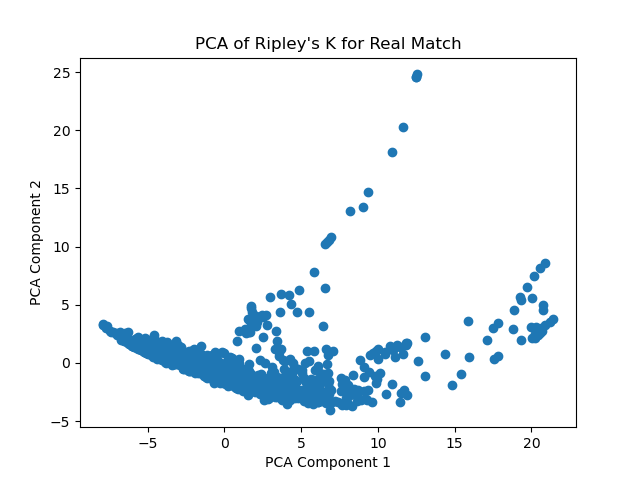

In [9]:
# Step 7: Calculate Ripley's K values for the real match data

ripley_k_vals_relevant = ripley_k_by_indices(one_match, relevant_situations)


#Added average position of team as feature

# Step 8: Perform PCA on the Ripley's K values from the real match data
pca_obj_ripley = PCAObject(ripley_k_whole_match, 10)  # Fit     PCA with 10 components
np_pca_ripley = pca_obj_ripley.transform(ripley_k_vals_relevant)
np_pca_ripley_full_match = pca_obj_ripley.transform(ripley_k_whole_match)

# Step 9: Plot the PCA-reduced Ripley's K values for the real match
plt.figure()
plt.scatter(np_pca_ripley_full_match[:, 0], np_pca_ripley_full_match[:, 1])
plt.title("PCA of Ripley's K for Real Match")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig("pca_ripley.png")
plt.show()

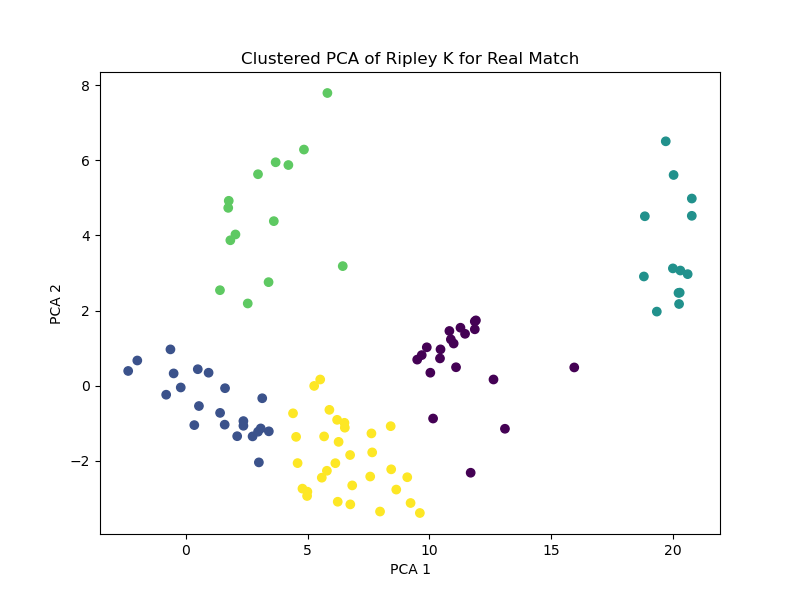

In [10]:
# Step 10: Cluster the PCA-reduced Ripley's K values using KMeans
clustering_obj_ripley = KMeansObject(np_pca_ripley, 5)  # Fit KMeans with 5 clusters
labels = clustering_obj_ripley.get_labels()

# Step 11: Plot the clustered PCA-reduced Ripley's K values
plt.figure(figsize=(8, 6))
plt.scatter(np_pca_ripley[:, 0], np_pca_ripley[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clustered PCA of Ripley K for Real Match')
plt.savefig("pca_ripley_clustered.png")
plt.show()

here


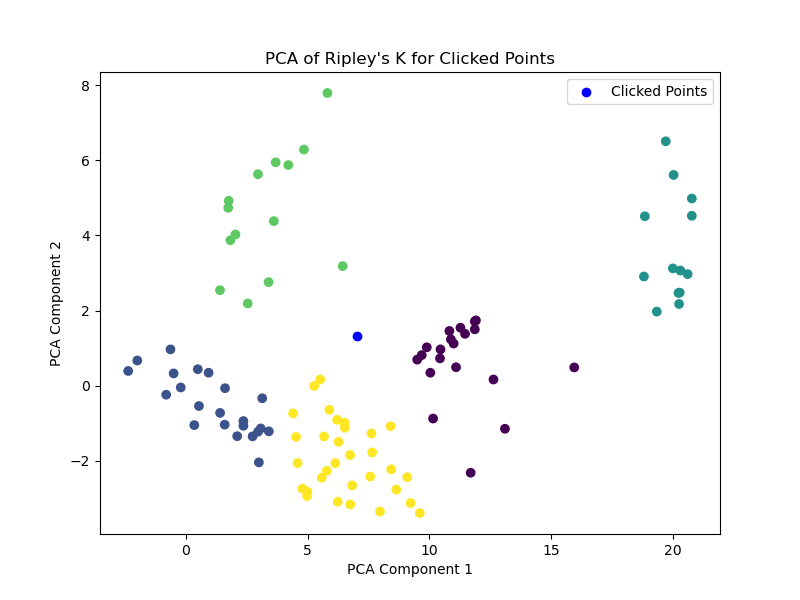

In [11]:
# Step 12: Apply PCA on the Ripley's K values for the clicked points
if points_array.shape[0] > 1:
    
    k_values_clicked_new = np.array(k_values_clicked).reshape(1, -1)  # Reshape for PCA compatibility
   



    
  
    reduced_k_values_clicked = pca_obj_ripley.transform(k_values_clicked_new)  # Transform using the same PCA model

    # Step 13: Plot the PCA-reduced clicked points

    plt.scatter(reduced_k_values_clicked[:, 0], reduced_k_values_clicked[:, 1], c='blue', label='Clicked Points')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title("PCA of Ripley's K for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

In [12]:
from sklearn.neighbors import KDTree

# Step 1: Build a KDTree from the PCA-reduced real match data
tree = KDTree(np_pca_ripley)

# Step 2: Query the 10 nearest neighbors for the clicked situation
distances, indices = tree.query(reduced_k_values_clicked, k=10)  # Find 10 nearest neighbors

# Flatten the indices
closest_indices = indices.flatten()
print("Closest situation indices:", closest_indices)


Closest situation indices: [ 0 49 31 85 34 40 13 88 59 93]


In [13]:
# Assuming `one_match` is a DataFrame where each row contains player positions for a specific situation
# Each row of `one_match` contains the player positions in the format: [(x1, y1), (x2, y2), ...]

# Retrieve the 10 closest situations from the real match

closest_situations_indices = np.array(top_100_alpha_shapes)[closest_indices,1]

print(closest_situations_indices)
closest_situations = one_match.loc[closest_situations_indices]


[13104 60288 60096 57936 49008 49056 49968 57888 12480 57792]


In [14]:
# Add time step columns to the closest situations. Each index is 24 time ticks
closest_situations

Time [s]  frame_team  Time [s]_team half_team  home_1_x  home_1_y  \
13104    524.16       13104         524.16        1H     28.22     -0.30   
60288   2411.52       60288        2411.52        1H     50.52      2.67   
60096   2403.84       60096        2403.84        1H     52.16      4.08   
57936   2317.44       57936        2317.44        1H     52.49      0.00   
49008   1960.32       49008        1960.32        1H     51.26      2.18   
49056   1962.24       49056        1962.24        1H     50.16      2.53   
49968   1998.72       49968        1998.72        1H     50.24     -2.20   
57888   2315.52       57888        2315.52        1H     52.47     -0.04   
12480    499.20       12480         499.20        1H     51.20      3.46   
57792   2311.68       57792        2311.68        1H     52.45      0.02   

       home_3_x  home_3_y  home_4_x  home_4_y  ...  away_16_y  away_17_x  \
13104    -34.21     -2.81    -35.20     -5.02  ...      -3.47     -26.50   
60288    -39.25     -8.79    -40.26      1.43  ...      -0.10     -43.06   
60096    -37.78     -8.91    -27.17     -0.03  ...       0.42     -40.08   
57936     13.40     -7.08     13.58      0.32  ...      -0.32      -1.80   
49008     44.49      2.27     44.76      7.29  ...       4.75      52.91   
49056     43.45      2.60     45.00      5.24  ...       6.75      43.92   
49968     36.41     -1.93     38.13     -2.15  ...       0.33      33.00   
57888     13.06     -6.89     12.11     -1.84  ...      -0.31      -2.63   
12480    -41.31     -6.87    -38.48      1.27  ...       0.20     -43.53   
57792     11.57     -4.38     10.91     -3.13  ...      -0.10      -2.85   

       away_17_y  away_22_x  away_22_y  away_23_x  away_23_y  ball_x  ball_y  \
13104      15.48     -35.52      -3.61     -41.63       0.14  -46.92   -2.09   
60288      18.53     -44.64       1.67     -43.16      -3.52  -52.69   23.49   
60096      12.08     -33.07       1.52     -45.31       6.43  -52.86   19.58   
57936      12.10      -0.53      19.26      -0.36      29.74   -6.12    0.97   
49008      25.98      44.49       2.68      41.36      13.30   45.82   21.19   
49056      29.52      43.13       3.76      38.24      18.22   40.75   31.19   
49968      -4.60      40.56       5.24      35.51      13.37   51.44   -5.46   
57888      11.74      -0.88      17.04      -0.34      29.74   -7.71    1.06   
12480      23.28     -42.06       4.56     -42.82      -2.16  -52.64   20.16   
57792      11.71      -0.28      13.18      -0.10      28.64  -10.90    1.26   

       Period  
13104       1  
60288       1  
60096       1  
57936       1  
49008       1  
49056       1  
49968       1  
57888       1  
12480       1  
57792       1  

[10 rows x 56 columns]

       Time [s]  frame_team  Time [s]_team half_team  home_1_x  home_1_y  \
13104    524.16       13104         524.16        1H     28.22     -0.30   
60288   2411.52       60288        2411.52        1H     50.52      2.67   
60096   2403.84       60096        2403.84        1H     52.16      4.08   
57936   2317.44       57936        2317.44        1H     52.49      0.00   
49008   1960.32       49008        1960.32        1H     51.26      2.18   
49056   1962.24       49056        1962.24        1H     50.16      2.53   
49968   1998.72       49968        1998.72        1H     50.24     -2.20   
57888   2315.52       57888        2315.52        1H     52.47     -0.04   
12480    499.20       12480         499.20        1H     51.20      3.46   
57792   2311.68       57792        2311.68        1H     52.45      0.02   

       home_3_x  home_3_y  home_4_x  home_4_y  ...  away_16_y  away_17_x  \
13104    -34.21     -2.81    -35.20     -5.02  ...      -3.47     -26.50   
60288    -3

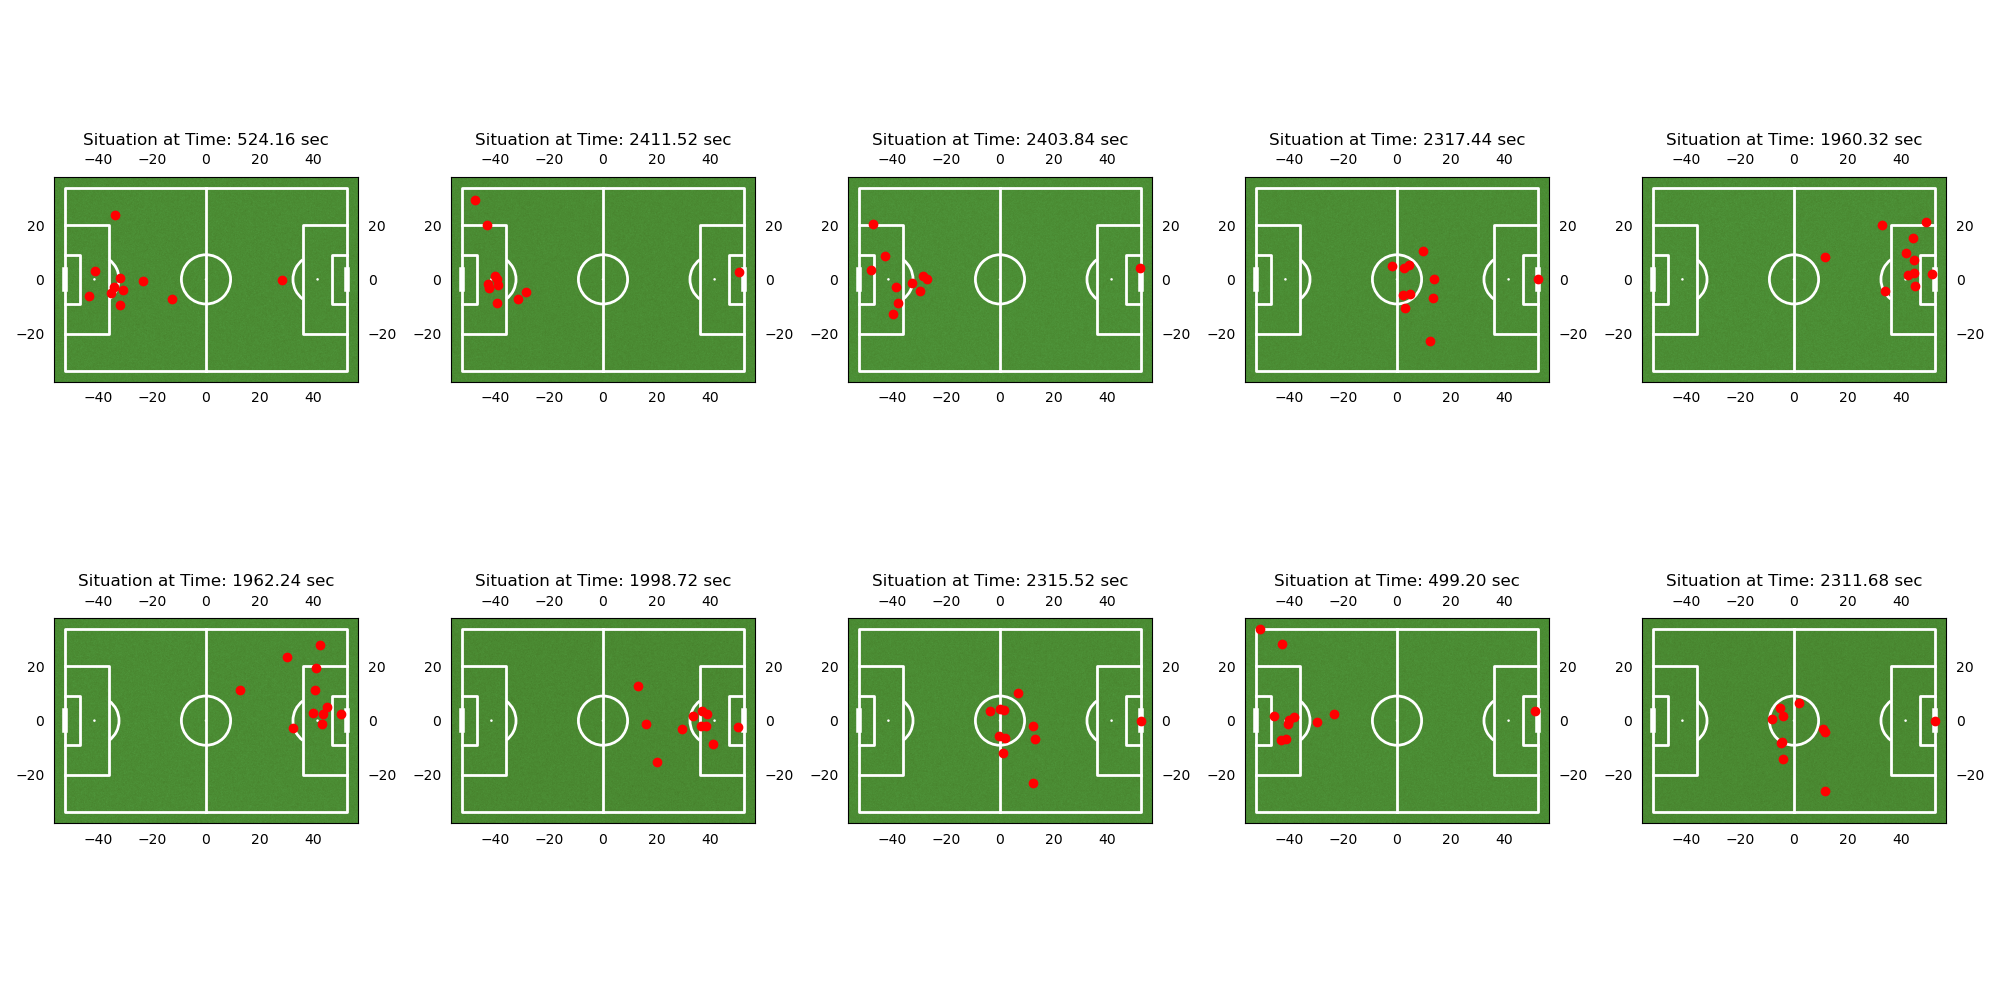

In [15]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import pandas as pd

# Function to extract player coordinates from the DataFrame
def extract_player_positions(row):
    # Extract home player positions (x and y)
    home_x_cols = [col for col in row.index if 'home' in col and '_x' in col]
    home_y_cols = [col for col in row.index if 'home' in col and '_y' in col]
    
    home_positions = [(row[x], row[y]) for x, y in zip(home_x_cols, home_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    # Extract away player positions (x and y)
    away_x_cols = [col for col in row.index if 'away' in col and '_x' in col]
    away_y_cols = [col for col in row.index if 'away' in col and '_y' in col]
    
    away_positions = [(row[x], row[y]) for x, y in zip(away_x_cols, away_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    return home_positions, away_positions

# Function to plot a single situation on the pitch
def plot_situation(row, ax):
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax)
    
    # Extract player positions from the row
    home_positions, away_positions = extract_player_positions(row)
    
    # Plot home team players (red)
    for pos in home_positions:
        ax.plot(pos[0], pos[1], 'ro', label='Home Team')  # Mark home players as red dots

    # Plot away team players (blue)
    #for pos in away_positions:
    #    ax.plot(pos[0], pos[1], 'bo', label='Away Team')  # Mark away players as blue dots
    
    ax.set_title(f"Situation at Time: {row['Time [s]']:.2f} sec")

# Step 4: Visualize the 10 closest situations on the pitch
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Create a grid for 10 situations
axes = axes.flatten()
print(closest_situations)

# Make sure closest_situations contains all required columns from the original DataFrame
if 'Time [s]' in closest_situations.columns:
    for idx, situation_index in enumerate(closest_situations.index):  # Use the index of the closest situations
        plot_situation(closest_situations.loc[situation_index], axes[idx])  # Pass the row to plot_situation
else:
    print("Ensure that closest_situations contains full rows, including player position columns.")

plt.tight_layout()
plt.show()


In [19]:
import vlc
import time
import tkinter as tk
from tkinter import Button, Label
import numpy as np

# Path to your video file
video_path = "/media/martinaguayo/thesis_drive/Thesis/Thesis_V1/data/EURO2020Russia_vs_Denmark_1st_Half_769630.mp4"

# Video offset in seconds (adjust this value to align video and match time)
video_offset = 52  # Example: If the video starts 2 minutes before the actual match starts

# Create a VLC instance
vlc_instance = vlc.Instance()

# Create a VLC media player
player = vlc_instance.media_player_new()

# Load the media file
media = vlc_instance.media_new(video_path)
player.set_media(media)

# Pause the video initially
player.play()
time.sleep(2)  # Wait for the video to load
player.pause()

# Function to seek to a specific time in seconds
def seek_to_time(player, seconds):
    if isinstance(seconds, (int, float)):  # Ensure that the time is a scalar number
        player.set_time(int((seconds + video_offset) * 1000))  # Add video_offset to align with match time

# Pause the video
def pause_video():
    player.pause()

# Resume the video
def play_video():
    player.play()

# Close the video properly and destroy the tkinter window
def close_video():
    if player.is_playing():
        player.stop()
    player.release()
    root.destroy()  # Close the tkinter window gracefully

# Function to update the current time in the video player
def update_time_label():
    current_time = player.get_time() // 1000  # Get current time in milliseconds, convert to seconds
    time_label.config(text=f"Time: {current_time} seconds")
    root.after(1000, update_time_label)  # Update every second

# Function to skip to the next closest situation time
def next_time():
    global current_index
    if len(closest_situations) > 0:
        current_index = (current_index + 1) % len(closest_situations)
        specific_time_in_seconds = closest_situations.iloc[current_index]['Time [s]']  # Extract the correct time from closest situations
        seek_to_time(player, specific_time_in_seconds)
        time_label.config(text=f"Time: {specific_time_in_seconds} seconds")

# Function to skip to the previous closest situation time
def previous_time():
    global current_index
    if len(closest_situations) > 0:
        current_index = (current_index - 1) % len(closest_situations)
        specific_time_in_seconds = closest_situations.iloc[current_index]['Time [s]']  # Extract the correct time from closest situations
        seek_to_time(player, specific_time_in_seconds)
        time_label.config(text=f"Time: {specific_time_in_seconds} seconds")

# Create the Tkinter window
root = tk.Tk()
root.title("VLC Video Control")

# Pause Button
pause_button = Button(root, text="Pause", command=pause_video)
pause_button.pack(side=tk.LEFT)

# Play Button
play_button = Button(root, text="Play", command=play_video)
play_button.pack(side=tk.LEFT)

# Next Button
next_button = Button(root, text="Next", command=next_time)
next_button.pack(side=tk.LEFT)

# Previous Button
previous_button = Button(root, text="Previous", command=previous_time)
previous_button.pack(side=tk.LEFT)

# Close Button
close_button = Button(root, text="Close", command=close_video)
close_button.pack(side=tk.LEFT)

# Time Label
time_label = Label(root, text="Time: 0 seconds")
time_label.pack(side=tk.LEFT)

# Initialize index for closest situations
current_index = 0

# Ensure closest_situations contains valid data and a 'Time [s]' column
if 'closest_situations' in globals() and not closest_situations.empty:
    specific_time_in_seconds = closest_situations.iloc[current_index]['Time [s]']  # Access the first situation's time
    print(f"Initial Time: {specific_time_in_seconds} seconds")
    seek_to_time(player, specific_time_in_seconds)
else:
    print("Error: closest_situations is not properly initialized or is empty.")

# Start updating the time label
update_time_label()

# Keep the video running
root.mainloop()


NameError: no function 'libvlc_new'